In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/departments.csv.zip
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
/kaggle/input/instacart-market-basket-analysis/orders.csv.zip
/kaggle/input/instacart-market-basket-analysis/products.csv.zip
/kaggle/input/instacart-market-basket-analysis/aisles.csv.zip


In [45]:
# For ignore the warnings
import warnings
warnings.filterwarnings("ignore")
# To see complete view of the product
pd.set_option('display.max_colwidth', -1)


# Import Packages

In [3]:
from zipfile import ZipFile  # working with zipped input
from mlxtend.frequent_patterns import fpgrowth, association_rules  # MBA
from scipy import sparse  # sparse matrices
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Extracting files from zip

In [4]:
# Loading & processing data
def preDot(text):
    return text.rsplit('.',1)[0]

np.random.seed(73)
dataDict = {}

for dirname,i,filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))
        with ZipFile(os.path.join(dirname,filename), 'r') as zipf:
            unzipped_fn = preDot(filename)
            with zipf.open(unzipped_fn) as f:
                dataDict[preDot(unzipped_fn)] = pd.read_csv(f)



/kaggle/input/instacart-market-basket-analysis/departments.csv.zip
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
/kaggle/input/instacart-market-basket-analysis/orders.csv.zip
/kaggle/input/instacart-market-basket-analysis/products.csv.zip
/kaggle/input/instacart-market-basket-analysis/aisles.csv.zip


## Get train data

In [6]:
#Dividing train_orders
train_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'train'].drop('eval_set', axis=1)
prior_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'prior'].drop('eval_set', axis=1)
test_orders = dataDict['orders'][dataDict['orders']['eval_set'] == 'test'].drop('eval_set', axis=1)

In [7]:
order_products__train = dataDict['order_products__train']

# Data Prepartion

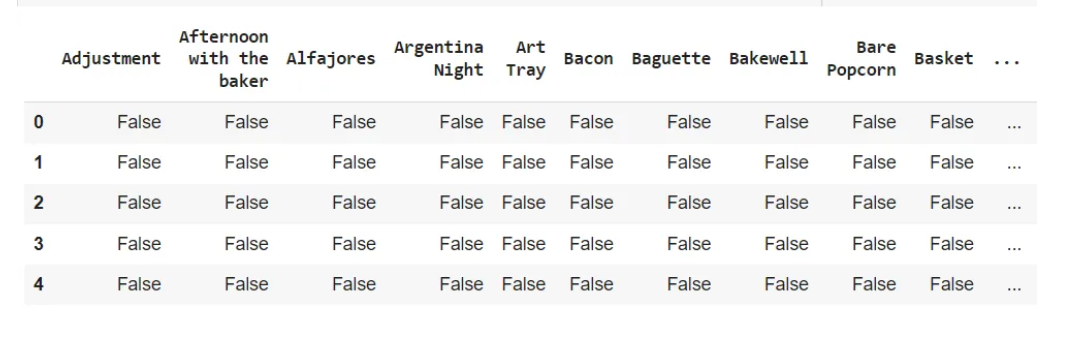

In [8]:
# we need our data is above format so use two column 
small_train = order_products__train[['order_id','product_id']]
small_train

,order_id,product_id
0,1,49302
1,1,11109
2,1,10246
3,1,49683
4,1,43633
...,...,...
1384612,3421063,14233
1384613,3421063,35548
1384614,3421070,35951
1384615,3421070,16953


In [43]:
# In Product csv files, product name are present
prod = dataDict['products']

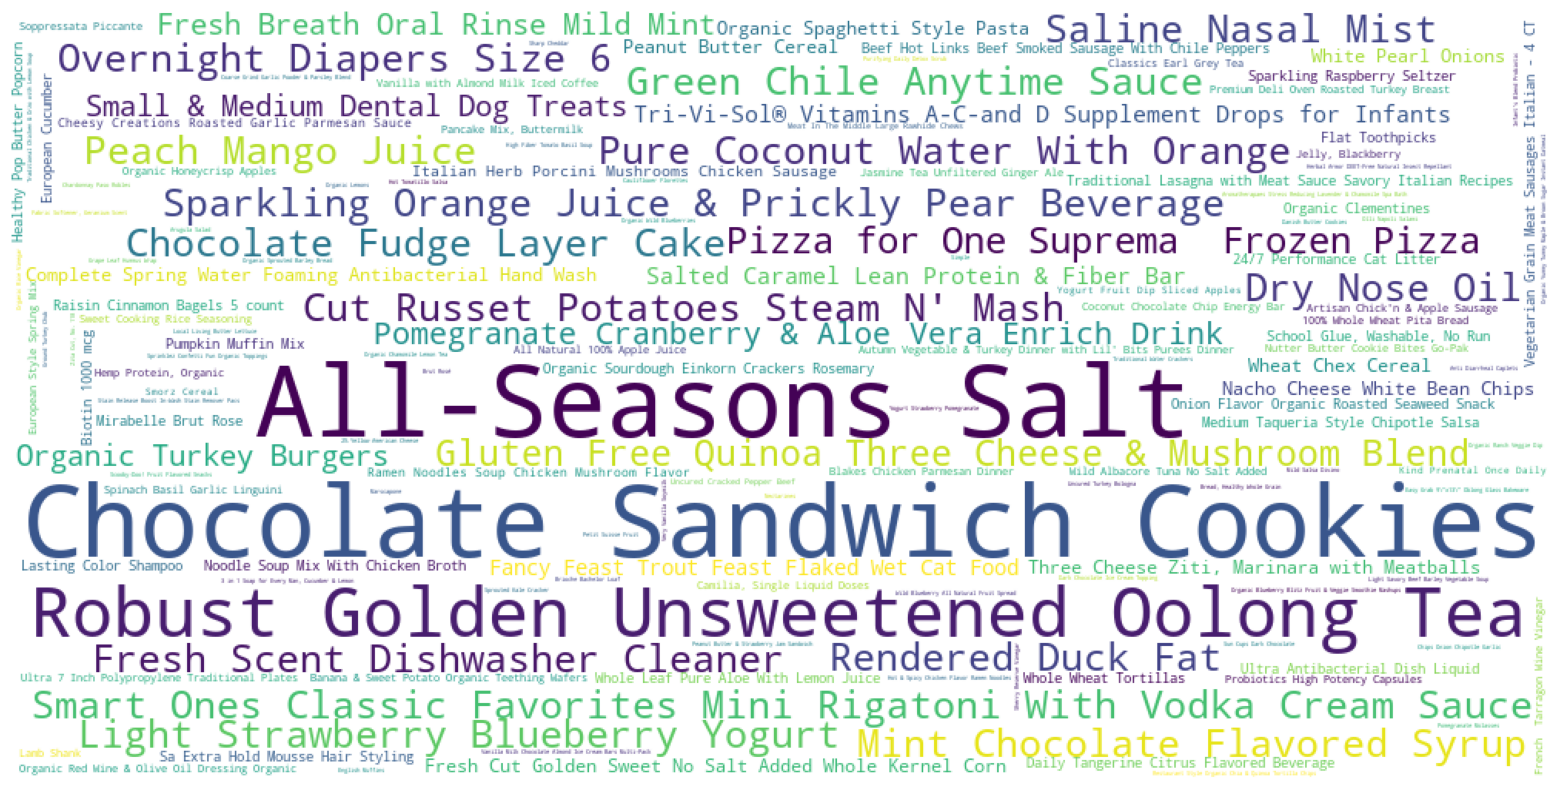

In [48]:
# create product counts using Counter() from collections package
from collections import Counter
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
import requests
product_counts = Counter(prod["product_name"])

wordcloud = WordCloud(width = 1000, 
                      height = 500,
                      background_color = 'white',
                      max_font_size = 90,
                      random_state = 9).generate_from_frequencies(product_counts)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wordcloud);
plt.savefig('stock_inventory.jpg')

In [50]:
df = order_products__train.merge(products,on='product_id')

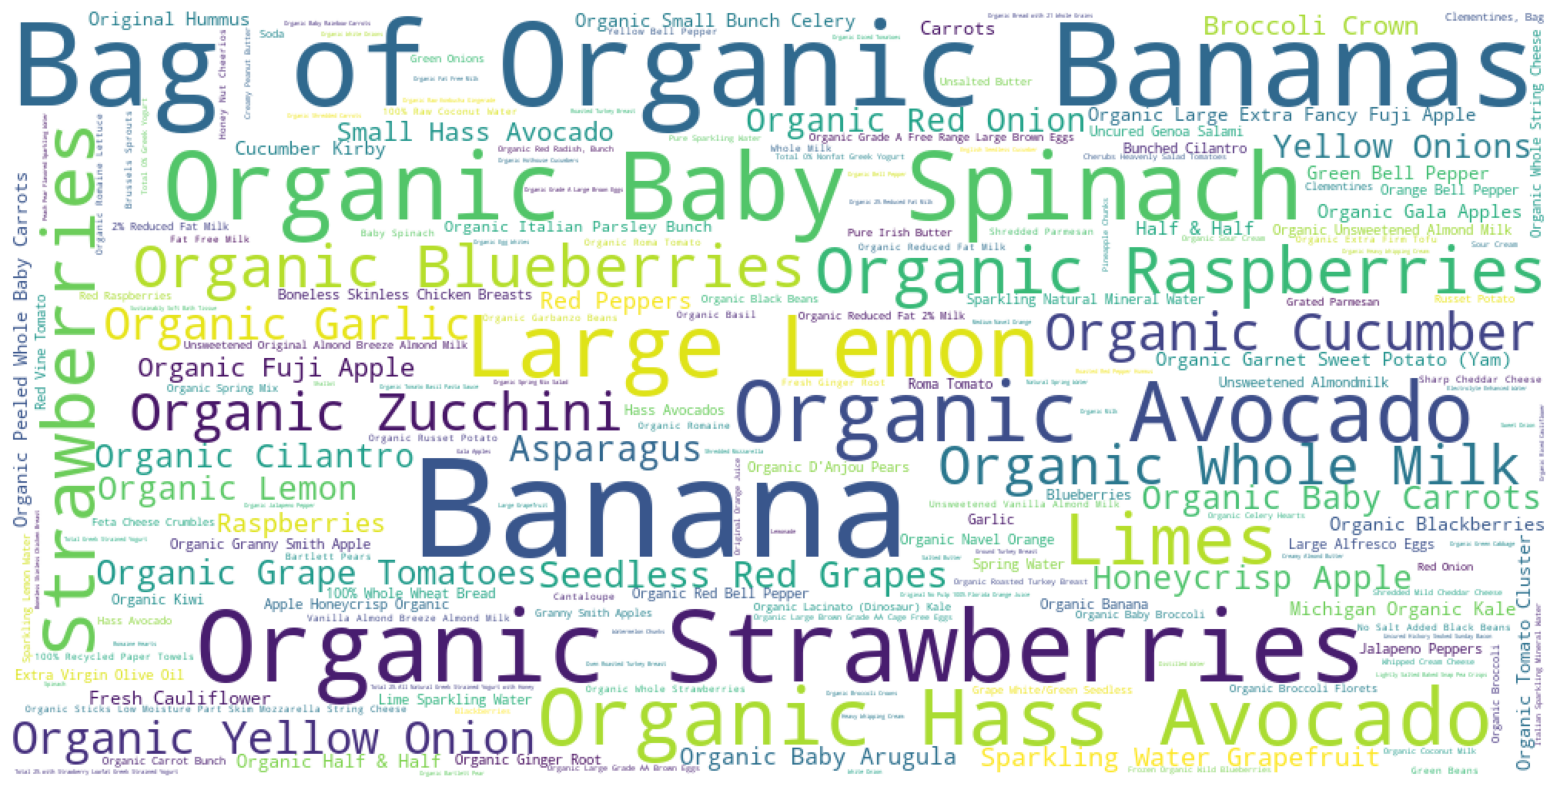

In [52]:
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
import requests
product_counts = Counter(df["product_name"])

wordcloud = WordCloud(width = 1000, 
                      height = 500,
                      background_color = 'white',
                      max_font_size = 90,
                      random_state = 9).generate_from_frequencies(product_counts)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wordcloud);
plt.savefig('selling_product.jpg')

In [53]:
# Split the train data so that it reduce the running time
small_train_split = (small_train[:461543], small_train[461543:461543*2-1], small_train[461543*2-1:])

In [55]:
#Getting list of unquie product id
pivots = []
for df in small_train_split:
    pvt = ~(df.pivot(index='order_id', columns='product_id', values='product_id').isna())
    pivots.append(pvt.astype(pd.SparseDtype(bool)))
del pvt

product_cols = sorted(small_train.product_id.unique())

In [57]:
len(product_cols)

39123

## Converting the table into data mining algorithm format 

In [14]:

for i in range(len(pivots)):
    # reindexing to add extra columns and standardize the format for vstack
    # we sparse them again here b/c otherwise we would end up having regular boolean columns
    pivots[i] = pivots[i].reindex(columns=product_cols, fill_value=False).astype(pd.SparseDtype(bool))
    pivots[i] = sparse.csr_matrix(pivots[i])
# concat vertically
pivots = sparse.vstack(pivots)

In [15]:
truth_table = pd.DataFrame(pivots.todense(), index=small_train.order_id.unique(), columns=product_cols)

In [16]:
truth_table.head()

,1,2,3,4,5,7,8,9,10,11,...,49677,49678,49679,49680,49681,49682,49683,49686,49687,49688
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Data mining algorithm 
Use the minimum support to filter out non-frequent item
> Other algorithm:
AIS, SETM and Apriori

In [17]:
# takes less than a minute to execute
frequent_itemsets = fpgrowth(truth_table, min_support=5/len(truth_table), use_colnames=True)

In [18]:
frequent_itemsets

,support,itemsets
0,0.117980,(13176)
1,0.055583,(47209)
2,0.018391,(49683)
3,0.015190,(22035)
4,0.008094,(10246)
...,...,...
861871,0.000053,"(8833, 9497)"
861872,0.000038,"(9497, 1134)"
861873,0.000038,"(9497, 8833, 1134)"
861874,0.000038,"(15317, 12902)"


# Compute and print the Association Rules

In [19]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

In [20]:
print("μ number of consequents:", rules['consequents'].apply(len).mean())
rules

μ number of consequents: 1.0391897394136809


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(47626, 49683, 4605, 21903)",(24852),0.000076,0.142719,0.000069,0.900000,6.306104,0.000058,8.572811
1,"(26209, 49683, 28204, 16797)",(24852),0.000046,0.142719,0.000038,0.833333,5.838985,0.000032,5.143687
2,"(49683, 39275, 48679)",(24852),0.000046,0.142719,0.000038,0.833333,5.838985,0.000032,5.143687
3,"(27104, 49683, 24964, 47766)",(24852),0.000038,0.142719,0.000038,1.000000,7.006782,0.000033,inf
4,"(42265, 40706, 49683, 24852)",(21903),0.000046,0.074568,0.000038,0.833333,11.175474,0.000035,5.552592
...,...,...,...,...,...,...,...,...,...
29467,(26460),(38936),0.000046,0.000099,0.000038,0.833333,8410.833333,0.000038,5.999406
29468,(3458),(24852),0.000053,0.142719,0.000046,0.857143,6.005813,0.000038,6.000968
29469,"(9497, 1134)",(8833),0.000038,0.000114,0.000038,1.000000,8747.266667,0.000038,inf
29470,(15317),(12902),0.000038,0.000122,0.000038,1.000000,8200.562500,0.000038,inf


In [21]:
# selecting out rules that might potentially not be enhancing
rules = rules[rules.lift > 1]

In [22]:
# a simplification of the table
rules_ante_cons = rules[['antecedents', 'consequents']]

# Recommendations

In [60]:
# creating customers' baskets
baskets = small_train.groupby('order_id')['product_id'].apply(frozenset)
baskets.name = "basket"  # antecedents

> Frozenset is similar to set in Python, except that frozensets are immutable, which implies that once generated, elements from the frozenset cannot be added or removed. This function accepts any iterable object as input and transforms it into an immutable object.

In [24]:
# Intialize one column with frozenset
recommendations = train_orders.join(baskets, on="order_id")
recommendations["recommendations"] = [frozenset() for _ in range(len(recommendations))]

In [25]:
recommendations['recommendations'].value_counts()

()    131209
Name: recommendations, dtype: int64

In [26]:
# computationally-intensive; might require an optimization
for idx, antecedent in enumerate(rules_ante_cons["antecedents"]):
    lookup = antecedent <= recommendations.basket, "recommendations"
    recommendations.loc[lookup] = recommendations.loc[lookup].apply(
        frozenset.union,
        args=(rules_ante_cons.loc[idx, "consequents"],)
    )
# recommendations = recommendations.rename(columns={"antecedents": "basket"})
# this may be changed earlier
recommendations.loc[:, "recommendations"] = recommendations.recommendations - recommendations.basket

In [28]:
# Removing all empty order, for that our reccommendation doesn't work
non_empty_recs = recommendations[recommendations.recommendations.apply(bool)]

# Assigning each product id with its product name

In [30]:

# non-empty recommendations
non_empty_recs = recommendations[recommendations.recommendations.apply(bool)]
print("1 out of approx.", round(1/(len(non_empty_recs) / len(recommendations))), "transactions will result in a recommendation being suggested to a customer.")
# mappin g codes to product names
def map_products(codes):
    if isinstance(codes, pd.Series):
        return codes.apply(map_products)
    return frozenset(map(products.get, codes))

products = dataDict["products"]
products = products.set_index("product_id")["product_name"].to_dict()
non_empty_recs.loc[:, ["basket", "recommendations"]] = non_empty_recs[["basket", "recommendations"]].apply(map_products)


1 out of approx. 14 transactions will result in a recommendation being suggested to a customer.


# Best product combination that small retail can also use

In [62]:
further = non_empty_recs[['basket','recommendations']]

In [89]:
# Filter rows based on number of items in "basket" column
filtered_rows = [row for row in range(len(further)) if len(further.iloc[row,0]) < 3]

# Create a new DataFrame with only the filtered rows
new_df = further.iloc[filtered_rows]

In [90]:
new_df

,basket,recommendations
482008,(0 Calorie Strawberry Dragonfruit Water Beverage),(0 Calorie Fuji Apple Pear Water Beverage)
1827443,"(Cheez-It Cheddar Cracker, Zero Calorie Cola)",(Soda)


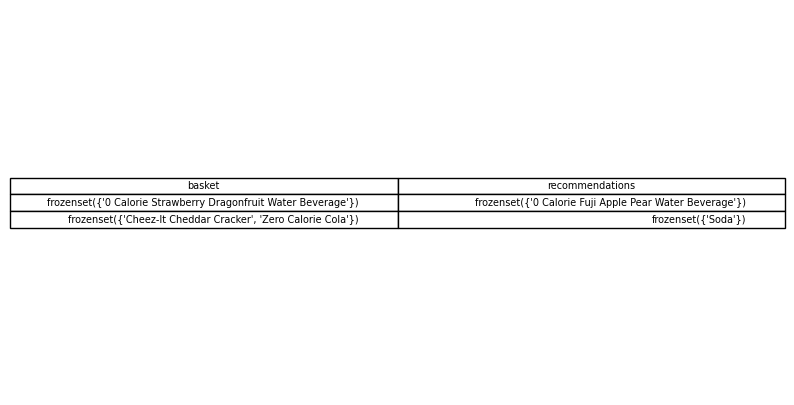

In [92]:
# Plot the DataFrame
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')
ax.table(cellText=new_df.values,colLabels=new_df.columns,loc='center')

# Save the plot as an image file
plt.savefig('best_combo.jpg')